# Project 2

## by Dion Ho


# Import Python Libraries

In [1]:
import numpy as np
import math
import scipy as sc
import time
import types
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from numpy import sin, cos, linspace, exp
from math import pi
from math import factorial
from matplotlib import pyplot as plt

# Q1

### Finite Difference Matrices

Using the finite difference formula,

\begin{align*}
&y''(x) = \frac{1}{h^2}y(x-h) - \frac{2}{h^2}y(x) + \frac{1}{h^2}y(x+h),
\end{align*}

the differential equation can be numerically expressed as

$$\frac{1}{h^2}\left(
\begin{array}{ccccccccc}
-2 & 1 & 0 & 0 & 0 & \ldots & 0 & 0 & 0\\
 1 & -2 & 1 & 0 & 0 & \ldots & 0 & 0 & 0\\
 0 & 1 & -2 & 1 & 0 & \ldots & 0 & 0 & 0\\
 \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
 0 & 0 & 0 & 0 & 0 &\ldots & 1 & -2 & 1 \\
 0 & 0 & 0 & 0 & 0 & \ldots & 0 & 1 & -2
 \end{array} \right)\left(
 \begin{array}{c}
 y(x_1) \\
 y(x_2) \\
 y(x_3) \\
 \vdots \\
 y(x_{n-1}) \\
 y(x_n)
 \end{array} \right) \hspace{1pc} + \hspace{1pc}
 \lambda\left(
 \begin{array}{c}
 \displaystyle y(x_1) + \frac{1}{\lambda h^2}y(x_0) \\
 y(x_2) \\
 y(x_3) \\
 \vdots \\
 y(x_{n-1}) \\
 \displaystyle y(x_n) + \frac{1}{\lambda h^2}y(x_{n+1})
 \end{array}\right) \hspace{1pc} = \hspace{1pc}
 \left(\begin{array}{c}
 0 \\
 0 \\
 0 \\
 \vdots \\
 0 \\
 0
 \end{array}\right)
 $$
 
 such that $y(x_0) = y(x_{n+1})$.
 
 ### Chebyshev Differentiation Matrices
 
 Using the Chebyshev Differentiation matrix,
 
 $$D_{n} := \left(\begin{array}{cccc}
 L'_1(x_1) & L'_2(x_1) & \ldots & L'_n(x_1) \\
 L'_1(x_2) & L'_2(x_2) & \ldots & L'_n(x_2) \\
 \vdots & \vdots & \ddots & \vdots \\
 L'_1(x_n) & L'_2(x_n) &\ldots & L'_n(x_n)
 \end{array} \right)$$
 
 the differential equation can be numerically expressed as
 
 $$([D_{n}]^2)\left(\begin{array}{c}
 y(x_1) \\
 y(x_2) \\
 \vdots \\
 y(x_n)
 \end{array} \right) \hspace{1pc} + \hspace{1pc} \lambda\left(\begin{array}{c}
 y(x_1) \\
 y(x_2) \\
 \vdots \\
 y(x_n)
 \end{array} \right) \hspace{1pc} = \hspace{1pc}
 \left(\begin{array}{c}
 0 \\
 0 \\
 \vdots \\
 0
 \end{array}\right)$$
 
 and we will need to separately verify that $y(x_0) = y(x_{n+1})$.

In [2]:
def chebspace(N,m=-1,M=1,Zero=False): #Returns N Chebyshev Extremum (Default) or Zero points in the specified interval (Default is [-1,1]).
    r = (m + M)/2
    if (Zero == True):
        pts = cos((np.array(range(N,0,-1)) - 0.5)*np.pi/N)
    else:
        pts = cos(np.array(range(N-1,-1,-1))*np.pi/(N-1))
    return (pts*(M - r) + r)

In [3]:
def chebdiffmat(x): #Returns the Chebyshev Differentiation Matrix
    N = len(x)-1
    DN = np.empty((N+1,N+1))
    def a(j):
        A = 1
        for k in range(0,N+1):
            if j != k:
                A *= x[j] - x[k]
        return A
    for i in range(0,N+1):
        for j in range(0,N+1):
            if i != j:
                DN[i,j] = a(i)/(a(j)*(x[i]-x[j]))
            else:
                E = 0
                for k in range(0,N+1):
                    if k != j:
                        E += 1/(x[j] - x[k])
                DN[i,j] = np.copy(E)
    return DN

In [4]:
def FD2mat(xvals): #Form the second order Finite Difference matrix.
    h = xvals[2:]-xvals[1:-1] #We assume that the points are equispaced.
    d0 = -2/h**2
    d1 = 1/h[1:]**2
    dm1 = 1/h[0:-1]**2
    # Create the FD matrix using the np.diag command.
    FD = np.diag(d0) + np.diag(d1,1) + np.diag(dm1,-1)
    
    return FD

In [5]:
def FD2mat_sp(xvals): #Form the second order Finite Difference matrix (use sparse matrices).
    h = xvals[2:]-xvals[1:-1] #We assume that the points are equispaced.
    d0 = -2/h**2
    d1 = 1/h[1:]**2
    dm1 = 1/h[0:-1]**2
    # Create the FD matrix using the sp.diags command.
    FD = sp.diags(d0) + sp.diags(d1,1)+ sp.diags(dm1,-1)
    
    return FD

#### First, we need to determine $y(x_0)$ and verify that $y(x_0) = y(x_{n+1})$

In [6]:
def yn(n,x):
    if n >= 0:
        return cos(n*x)
    else:
        return sin(n*x)
    
for n in range(-2,3):
    print("For n =",n,", y(x_0) =",yn(n,0),"and y(x_{n+1}) =",yn(n,2*pi))

For n = -2 , y(x_0) = 0.0 and y(x_{n+1}) = 4.898587196589413e-16
For n = -1 , y(x_0) = 0.0 and y(x_{n+1}) = 2.4492935982947064e-16
For n = 0 , y(x_0) = 1.0 and y(x_{n+1}) = 1.0
For n = 1 , y(x_0) = 1.0 and y(x_{n+1}) = 1.0
For n = 2 , y(x_0) = 1.0 and y(x_{n+1}) = 1.0


Therefore, we have verified that the eigenfunctions fulfill the $2\pi $ periodic boundary condition. This is very much expected since $\forall n \in \mathbb{N}, \cos(nx)$ and $\sin(nx)$ are $2\pi $ periodic.

In [7]:
N = 200
xlin = linspace(0,2*pi,N) #We will use 200 grid points between 0 and 2*pi inclusive.
xcheb = chebspace(N,0,2*pi)
chebdiffm = chebdiffmat(xcheb)
FDm = FD2mat(xlin)

print("Using Finite Difference matrices,")
for n in range(-2,3):
    Lbc = yn(n,0)
    Rbc = yn(n,2*pi)
    firstterm = FDm@yn(n,xlin)[1:-1] #"First term" means first term of the differential equation.
    secondterm = (n**2)*yn(n,xlin[1:-1])
    secondterm[0] = secondterm[0] + (((N-1)/(2*pi))**2)*Rbc
    secondterm[N-3] = secondterm[N-3] + (((N-1)/(2*pi))**2)*Lbc
    print("For n =",n,", The Euclidean norm =",np.linalg.norm(firstterm + secondterm)) #We want the norm to be zero.
    #We ignore the boundary points when calculating the norm since the boundary points are not governed by the differential equation.
print()
print("Using the Chebyshev Differentiation matrix,")
for n in range(-2,3):
    Lbc = yn(n,0)
    Rbc = yn(n,2*pi)
    print("For n =",n,", The Euclidean norm =",np.linalg.norm((chebdiffm@chebdiffm@yn(n,xcheb))[1:-1] + (n**2)*yn(n,xcheb)[1:-1]))

Using Finite Difference matrices,
For n = -2 , The Euclidean norm = 0.01325702680677419
For n = -1 , The Euclidean norm = 0.0008286467790147509
For n = 0 , The Euclidean norm = 8.590525538142624e-10
For n = 1 , The Euclidean norm = 0.000824472206023864
For n = 2 , The Euclidean norm = 0.013190240349579385

Using the Chebyshev Differentiation matrix,
For n = -2 , The Euclidean norm = 6.705248434893083e-11
For n = -1 , The Euclidean norm = 6.375341902522307e-11
For n = 0 , The Euclidean norm = 1.6741222764269936e-08
For n = 1 , The Euclidean norm = 1.660467139811718e-08
For n = 2 , The Euclidean norm = 1.7331042003408333e-08


Recall that the differential equation is given by

$$\frac{d^2y}{dx^2} + \lambda y = 0$$

Theoretically, we expect the norm

$$\left\|\frac{d^2y}{dx^2} + \lambda y\right\|$$

to be zero if $\lambda$ are the eigenvalues and $y_n(x)$ are the corresponding eigenfunctions. Indeed, the norms we found through our numerical methods are close enough to zero that we can be confident that we have the eigenvalues and their corresponding eigenfunctions.

Therefore, the value of the norms we attained indicate the inaccuracy in each numerical method. It is evident that the Chebyshev Differentiation matrix method is much more accurate than the Finite Difference method since the former produced norms which are much closer to zero. Interestingly, the Finite Difference method is very accurate when $n=0$, however, for larger values of $n$, the method becomes much less accurate.

The eigenvalues $1$, corresponding to $n = -1,1$, and $4$, corresponding to $n = -2,2$, are repeated.

### Runtime Tests

In [8]:
N = 100
xlin = linspace(0,2*pi,N)
xcheb = chebspace(N,0,2*pi)
chebdiffm = chebdiffmat(xcheb)

trials = 1000
avg1,avg2,avg3,avg4,avg5 = 0,0,0,0,0
for jj in range(0,trials): 
    start_time = time.time()
    FDm = FD2mat_sp(xlin)
    FDm@yn(n,xlin)[1:-1]
    end_time = time.time()
    avg1+=(end_time-start_time)

    start_time = time.time()
    FDm = FD2mat(xlin)
    FDm@yn(n,xlin)[1:-1]
    end_time = time.time()
    avg2+=(end_time-start_time)
    
    FDm = FD2mat_sp(xlin)
    start_time = time.time()
    FDm@yn(n,xlin)[1:-1]
    end_time = time.time()
    avg3+=(end_time-start_time)

    #start_time = time.time() #This block of code is commented out since it takes a long time to build a Cheb. Diff. matrix.
    #chebdiffm = chebdiffmat(xcheb)
    #chebdiffm@chebdiffm@yn(n,xcheb)
    #end_time = time.time()
    #avg4+=(end_time-start_time)

    start_time = time.time()
    chebdiffm@chebdiffm@yn(n,xcheb)
    end_time = time.time()
    avg5+=(end_time-start_time)
print("Runtime of FD method using a sparse matrix")
print(avg1/trials,"\n")
print("Runtime of FD method using a dense matrix")
print(avg2/trials,"\n")
print("Runtime of FD method ignoring construction of the FD matrix and using the sparse package for multiplication")
print(avg3/trials,"\n")
#print("Runtime of Cheb method")
#print(avg4/trials,"\n")
print("Runtime of Cheb method ignoring construction of Cheb Diff. matrix")
print(avg5/trials,"\n")

Runtime of FD method using a sparse matrix
0.0008099067211151123 

Runtime of FD method using a dense matrix
0.00032211112976074217 

Runtime of FD method ignoring construction of the FD matrix and using the sparse package for multiplication
2.285289764404297e-05 

Runtime of Cheb method ignoring construction of Cheb Diff. matrix
0.00039661407470703125 



The biggest runtime disadvantage of the Cheb Diff. matrix method is that the construction of the Chebyshev matrix takes about $0.9$s. However, the construction of the Cheb Diff. matrix can be made much more efficient and we only need to construct the matrix once to calculate multiple eigenvalues/eigenfunctions. We need to rebuild the Cheb Diff. matrix and the FD matrix only if the number of grid points is changed.

Overall, the Finite Difference method still has an advantage in runtime since one can use the sparse package with it to achieve extremely low runtimes. The FD method at its fastest involves prebuilding the FD matrix as a sparse matrix and using the sparse package for matrix multiplication. The FD method at its fastest is two orders of magnitude faster than the Cheb. Diff. method at its fastest (with the Cheb. Diff. matrix prebuilt). This is because Cheb Diff. matrices are dense. In summary, the Finite Difference method is faster, but the Cheb. Diff. matrix method is more accurate.

## Q2

We want to solve the differential equation:

$$\frac{d^2y}{dx^2} + (\lambda + 10 \cos(x)) y(x) = \lambda y.$$

Let $FD$ be the second-order Finite Difference matrix, then we have an eigenvalue problem which we can approximate as

$$\left(-FD-10 \cos(x)\right)y = \lambda y.$$

Given periodic boundary conditions, we can express the problem as

$$-\left(\frac{1}{h^2}\left(
\begin{array}{ccccccccc}
 -2 & 1 & 0 & 0 & 0 & \ldots & 0 & 0 & 1\\
 1 & -2 & 1 & 0 & 0 & \ldots & 0 & 0 & 0\\
 0 & 1 & -2 & 1 & 0 & \ldots & 0 & 0 & 0\\
 \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
 0 & 0 & 0 & 0 & 0 &\ldots & 1 & -2 & 1 \\
 1 & 0 & 0 & 0 & 0 & \ldots & 0 & 1 & -2
 \end{array} \right) \hspace{0.5pc} + \hspace{0.5pc} 10\left(
\begin{array}{ccccccccc}
 \cos(x_0) & 0 & 0 & 0 & 0 & \ldots & 0 & 0 & 0\\
 0 &  \cos(x_1) & 0 & 0 & 0 & \ldots & 0 & 0 & 0\\
 0 & 0 &  \cos(x_2) & 0 & 0 & \ldots & 0 & 0 & 0\\
 \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
 0 & 0 & 0 & 0 & 0 &\ldots & 0 &  \cos(x_n) & 0 \\
 0 & 0 & 0 & 0 & 0 & \ldots & 0 & 0 &  \cos(x_{n+1})
 \end{array} \right)\right)\hspace{0.5pc}\times\hspace{1pc}\left(
 \begin{array}{c}
 y(x_0) \\
 y(x_1) \\
 y(x_2) \\
 \vdots \\
 y(x_n) \\
 y(x_{n+1})
 \end{array} \right) = \lambda\left(
 \begin{array}{c}
 y(x_0) \\
 y(x_1) \\
 y(x_2) \\
 \vdots \\
 y(x_n) \\
 y(x_{n+1})
 \end{array} \right),$$
 
 and solve for the eigenvalues and corresponding eigenvectors of $\left(-FD-10 \cos(x)\right)$.

In [9]:
def FD2mat2(xvals,epsi): #Form the matrix for which we want to find the eigenvalues.
    N = len(xvals)
    hh = abs(xvals[1]-xvals[0]) #We assume that the points are equispaced.
    h = np.ones(N)*hh
    d0 = -2/h**2
    d1 = 1/h[1:]**2
    dm1 = 1/h[0:-1]**2
    # Create the FD matrix using the np.diag command
    FD = np.diag(d0) + np.diag(d1,1)+ np.diag(dm1,-1)
    FD[0,N-1] = 1/hh**2 #These are the periodic boundary conditions
    FD[N-1,0] = 1/hh**2
    FD = FD + epsi*np.diag(cos(xvals))
    FD = -FD
    
    return FD

In [10]:
G = 2**7 #This is the dimension of the square matrix.
xlin = linspace(0,2*pi,G)
FDm = FD2mat2(xlin,10)

In [11]:
def InvPwrMtd_edit(A,mu): #This edited version of the algorithm attempts to deal with the singular matrix that is formed when an exact eigenvalue is inputed.
    m,n = np.shape(A)
    x0 = np.random.random(n)
    x0 = np.copy(x0/np.linalg.norm(x0,ord=2))
    Q,R = sc.linalg.qr(A - mu*np.eye(n))
    for k in range(0,n):
        try:
            x1 = sc.linalg.solve_triangular(R,np.matmul(np.matrix.getH(Q),x0))
        except:
            return mu, np.empty(n)
        x1 = np.copy(x1/np.linalg.norm(x1,ord=2))
        x0 = x1
    return np.matmul(np.matmul(np.matrix.getH(x1),A),x1), x1

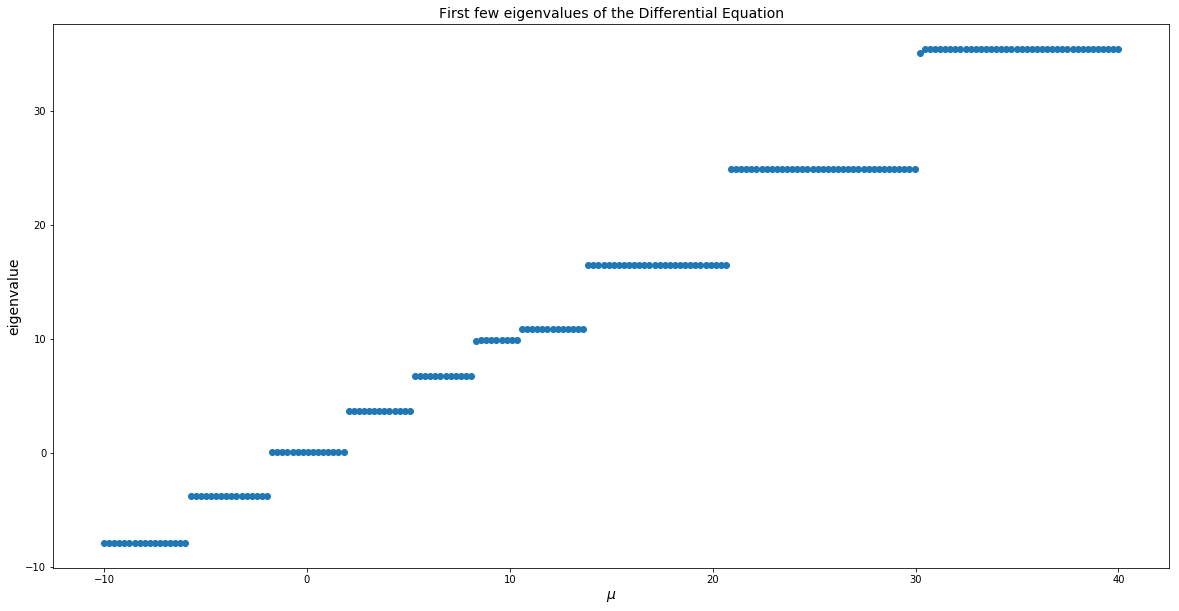

In [12]:
#This algorithm will take about 30s to run.
N = 200 #This is the grid spacing of mu values.
e = np.empty(N)
v = np.empty((G,N))
q = linspace(-10,40,N)
for kk in range(0,N):
    e[kk],v[:,kk] = InvPwrMtd_edit(FDm,q[kk]) #Every column of v is an eigenvector.
plt.figure(figsize=(20,10))
plt.title("First few eigenvalues of the Differential Equation", fontsize = 14)
plt.xlabel("$\mu$", fontsize = 14)
plt.ylabel("eigenvalue", fontsize = 14)
plt.plot(q,e,'o')

The inverse power method returns the eigenvalue closest to the $\mu$ we input. In order to find the first $8$ eigenvalues we increase the value of $\mu$ until find $8$ convergence values (i.e. the y-values of the $8$ horizontal lines). These are the eigenvalues of our matrix. Note that the algorithm is unstable when $\mu$ is about equidistant from two eigenvalues, hence the few anomalous points in between horizontal lines.

In [13]:
geteig = 8 #This is the number of eigenvalues to get
print("The first 8 eigenvalues are:")

count = 0
i = 0
uniquee = np.empty(geteig)
uniquev = np.empty((G,geteig))
for k in range(1,N):
    if abs(e[k] - e[k-1]) < 1e-5:
        count += 1
    elif (count > 1):
        count = 0
        print(e[k-1])
        uniquee[i] = e[k-1]
        uniquev[:,i] = v[:,k-1]
        i += 1
        if i == geteig:
            break
if i == geteig-1:
    uniquee[i] = e[N-1]
    uniquev[:,i] = v[:,N-1]
    print(e[N-1])

The first 8 eigenvalues are:
-7.915354620474267
-3.7899955420399736
0.09536296919211804
3.661100805343641
6.709873583905731
9.911291450123436
10.856846369953171
16.45100549964558


In [14]:
print("The first 8 eigenvalues from Numpy's Eigenvalue Solver:")
print(sorted(np.linalg.eig(FDm)[0])[0:8])
print()
print("Difference in eigenvalues from Numpy's Eigenvalue Solver and our Inverse Power method")
print(uniquee - sorted(np.linalg.eig(FDm)[0])[0:8])

The first 8 eigenvalues from Numpy's Eigenvalue Solver:
[-7.91535462047595, -3.7899955420724467, 0.09536296919120621, 3.661100805340681, 6.709873583905915, 9.911291450122214, 10.85684636995264, 16.451005499646374]

Difference in eigenvalues from Numpy's Eigenvalue Solver and our Inverse Power method
[ 1.68309811e-12  3.24731353e-11  9.11826170e-13  2.95985458e-12
 -1.83852933e-13  1.22213351e-12  5.31130695e-13 -7.95807864e-13]


Our inverse power method does not detect multiple eigenvalues, however, Numpy's eigenvalue solver shows that when $\epsilon = 10$ there are no duplicated eigenvalues. The eigenvalues produced by Numpy's eigenvalue solver is very similar to the eigenvalues we found which gives us confidence that we have determined the eigenvalues accurately.

Quite unlike the eigenvalues in Q1, the matrix in Q2 has negative eigenvalues.

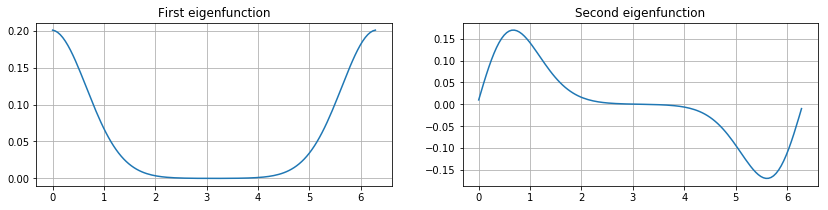

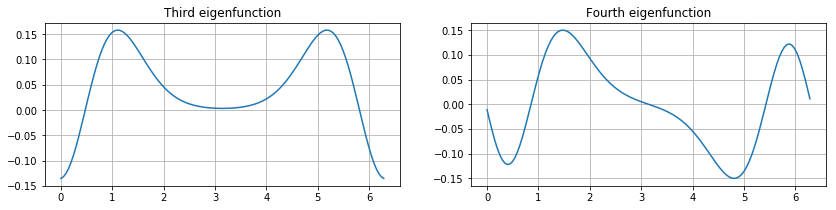

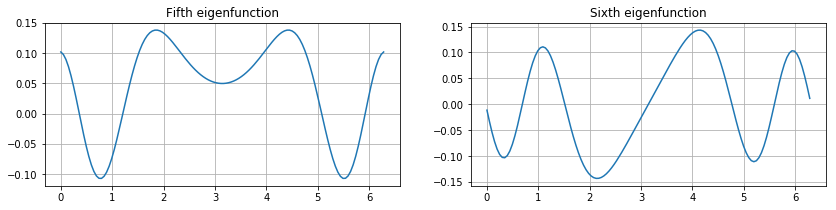

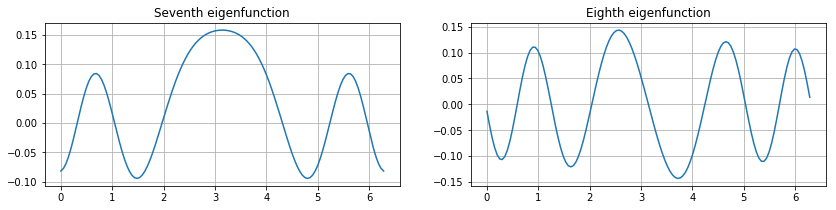

In [15]:
plt.figure(figsize=(14, 3))
plt.subplot(1,2,1)
plt.plot(xlin,uniquev[:,0])
plt.title("First eigenfunction")
plt.grid()

plt.subplot(1,2,2)
plt.plot(xlin,uniquev[:,1])
plt.title("Second eigenfunction")
plt.grid()

plt.figure(figsize=(14, 3))
plt.subplot(1,2,1)
plt.plot(xlin,uniquev[:,2])
plt.title("Third eigenfunction")
plt.grid()

plt.subplot(1,2,2)
plt.plot(xlin,uniquev[:,3])
plt.title("Fourth eigenfunction")
plt.grid()

plt.figure(figsize=(14, 3))
plt.subplot(1,2,1)
plt.plot(xlin,uniquev[:,4])
plt.title("Fifth eigenfunction")
plt.grid()

plt.subplot(1,2,2)
plt.plot(xlin,uniquev[:,5])
plt.title("Sixth eigenfunction")
plt.grid()

plt.figure(figsize=(14, 3))
plt.subplot(1,2,1)
plt.plot(xlin,uniquev[:,6])
plt.title("Seventh eigenfunction")
plt.grid()

plt.subplot(1,2,2)
plt.plot(xlin,uniquev[:,7])
plt.title("Eighth eigenfunction")
plt.grid()

In [16]:
print("Difference in the value of the boundary points (should be zero)")
for j in range(0,8):
    print("Eigenfunction",j+1,":",uniquev[0,j] - uniquev[G-1,j])

Difference in the value of the boundary points (should be zero)
Eigenfunction 1 : 1.1721032477929327e-10
Eigenfunction 2 : 0.019945441691485835
Eigenfunction 3 : -1.0400916489183842e-08
Eigenfunction 4 : -0.022124277162487556
Eigenfunction 5 : -2.220446049250313e-16
Eigenfunction 6 : -0.022776193960144044
Eigenfunction 7 : 6.106226635438361e-16
Eigenfunction 8 : -0.02724473483816716


The $8$ eigenfunctions are $2\pi$ periodic as expected. It appears that for odd numbered eigenfunctions (where the graph approaches the two boundary points from opposite directions), there is some inaccuracy since the difference in the value of the two boundary points of the graph does not equal zero.

## Q3

We will use the faster singleshift algorithm for Q3; we will save time by not calculating the eigenfunctions.

In [17]:
def singleshift(A,N,tol=1e-8):
    m,n = np.shape(A)
    if n == 1:
        return A[0][0]
    if n == 2:
        alpha = np.matrix.trace(A[0:2,0:2])
        beta = np.linalg.det(A[0:2,0:2])
        if alpha**2 - 4*beta >= 0:
            eig1 = 0.5*(alpha+np.sqrt(alpha**2 - 4*beta))
            eig2 = 0.5*(alpha-np.sqrt(alpha**2 - 4*beta))
            return eig1, eig2
        return ()
    S = sc.linalg.hessenberg(A) #We use inbuilt code to form the hessenberg matrix of A.
    for k in range(0,N):
        mu = np.copy(S[n-1,n-1])
        Q,R = np.linalg.qr(S-mu*np.eye(n))
        S = np.matmul(R,Q) + mu*np.eye(n)
        for j in range(0,m-1):
            if abs(S[j,j+1]) < tol:
                S[j,j+1] = S[j+1,j] = 0
    return singleshift(S[0:m//2,0:n//2],N), singleshift(S[m//2:,n//2:],N)

In [18]:
def flatten(T):
    if type(T) != tuple:
        return (T,)
    elif len(T) == 0: 
        return ()
    else: 
        return flatten(T[0]) + flatten(T[1:])

In [19]:
#This algorithm will take about a minute.
G = 2**6 #This is the dimension of the square matrix (we'll use a smaller matrix for faster runtime).
xlin = linspace(0,2*pi,G)
epsi = linspace(0,20,42)

earr = np.empty((42,8))
for j in range(0,42):
    FDm = FD2mat2(xlin,epsi[j])
    earr[j,:] = sorted(flatten(singleshift(FDm,G)))[0:8]

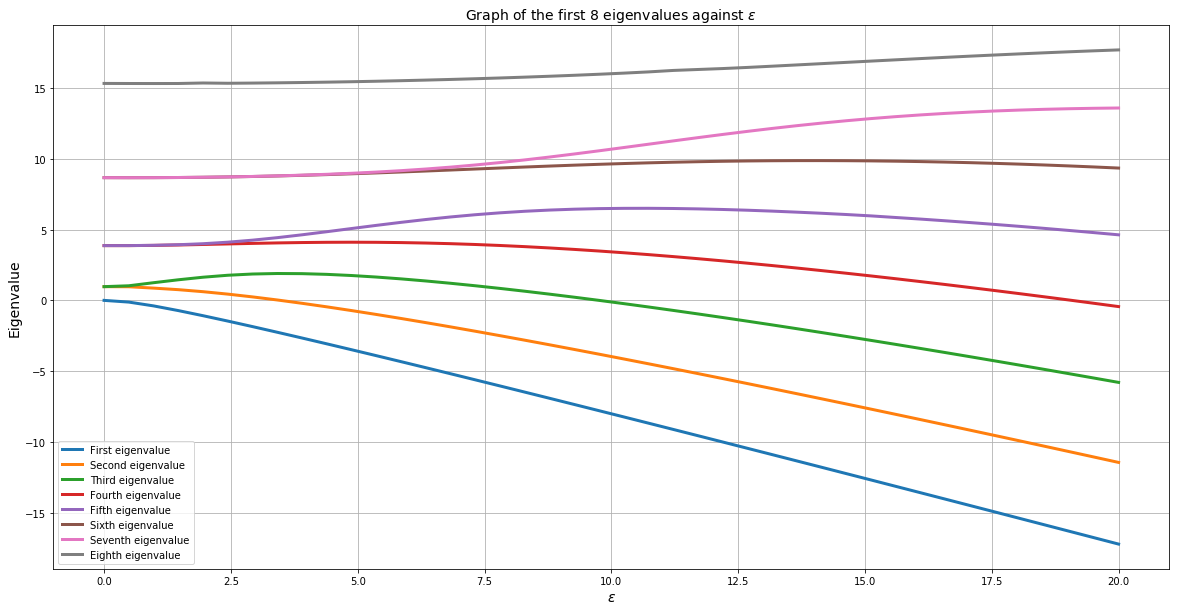

In [20]:
plt.figure(figsize=(20,10))
plt.title("Graph of the first $8$ eigenvalues against $\epsilon$", fontsize = 14)
plt.xlabel("$\epsilon$", fontsize = 14)
plt.ylabel("Eigenvalue", fontsize = 14)
for kk in range(0,8):
    plt.plot(epsi,earr[:,kk],linewidth=3)
plt.legend(["First eigenvalue","Second eigenvalue","Third eigenvalue","Fourth eigenvalue","Fifth eigenvalue","Sixth eigenvalue","Seventh eigenvalue","Eighth eigenvalue"])
plt.grid()

The graph shows that when $\epsilon = 0$ out of the first $8$ eigenvalue there are $3$ duplicate pairs. As $\epsilon$ increases the duplicate pairs of eigenvalues diverge. Moreover, while there are no negative eigenvalues when $\epsilon = 0$, as $\epsilon$ increases there begin to be some (and eventually more) negative eigenvalues.

We are somewhat confident in our numerical solutions as we attained them through three different methods: our singleshift algorithm, Numpy's eigenvalue solver, and our inverse power algorithm. We can be confident at least that the eigenvalues we attained are about as accurate as they can be without changing the size of the matrix. Nonetheless, we can validate our solutions by checking if

$$\left\|\frac{d^2y}{dx^2} + (\lambda + \epsilon \cos(x))y\right\| = 0$$

for each $\lambda$ and $\epsilon$. This would be identical to what we did in Q1. Alternatively, we can increase the number of grid points incorporated in our matrix and check for how well the eigenvalues have converged. For the second method we should reuse our original grid points when we increase the number of grid points. This is because the eigenvalues we attain are dependent on the placement of our grid points.

In [21]:
G = 2**7+1 #This is the dimension of the original square matrix.
xlin = linspace(0,2*pi,G)
FDm = FD2mat2(xlin,10)

G = 2**8+1 #This is the dimension of the enlarged square matrix.
xlin = linspace(0,2*pi,G)
FDm2 = FD2mat2(xlin,10)

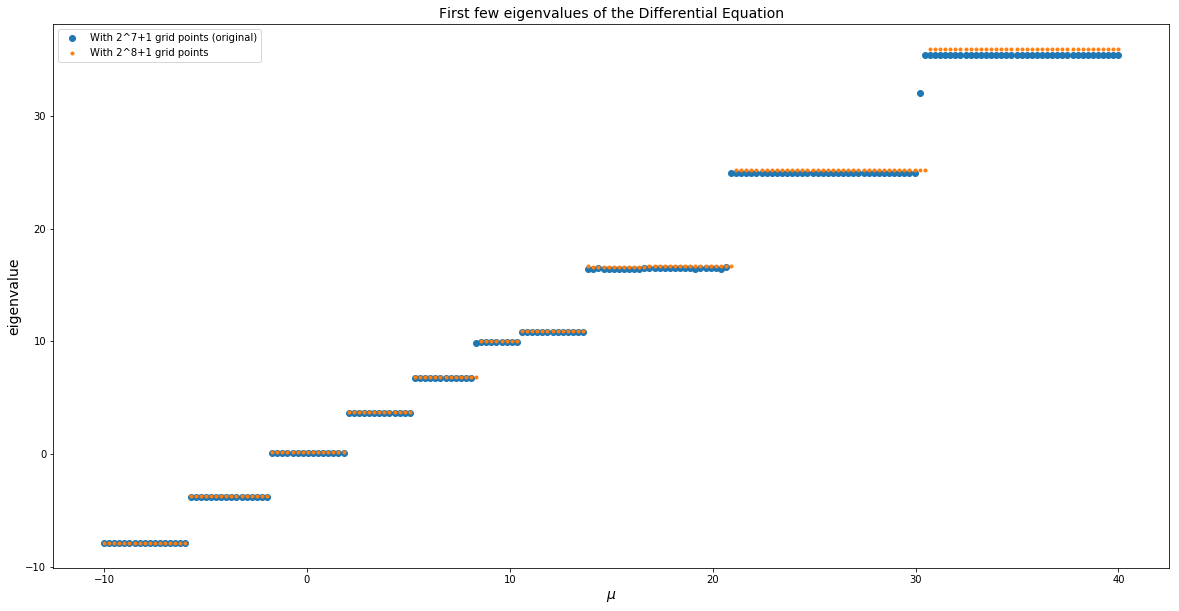

In [22]:
#This algorithm will take about a minute to run.
N = 200 #This is the grid spacing of mu values.
e = np.empty(N)
e2 = np.empty(N)
q = linspace(-10,40,N)
for kk in range(0,N):
    e[kk],u = InvPwrMtd_edit(FDm,q[kk]) #Every column of v is an eigenvector.
    e2[kk],u = InvPwrMtd_edit(FDm2,q[kk]) #Every column of v is an eigenvector.
plt.figure(figsize=(20,10))
plt.title("First few eigenvalues of the Differential Equation", fontsize = 14)
plt.xlabel("$\mu$", fontsize = 14)
plt.ylabel("eigenvalue", fontsize = 14)
plt.plot(q,e,'o')
plt.plot(q,e2,'.')
plt.legend(["With 2^7+1 grid points (original)","With 2^8+1 grid points"])

In [23]:
geteig = 8 #This is the number of eigenvalues to get
print("The difference in the first 8 eigenvalues are:")

count = 0
i = 0
uniquee = np.empty(geteig)
for k in range(1,N):
    if abs(e[k] - e[k-1]) < 1e-6:
        count += 1
    elif (count > 1):
        count = 0
        uniquee[i] = e[k-1]
        i += 1
        if i == geteig:
            break
if i == geteig-1:
    uniquee[i] = e[N-1]
    
count = 0
i = 0
uniquee2 = np.empty(geteig)
for k in range(1,N):
    if abs(e2[k] - e2[k-1]) < 1e-6:
        count += 1
    elif (count > 1):
        count = 0
        uniquee2[i] = e2[k-1]
        i += 1
        if i == geteig:
            break
if i == geteig-1:
    uniquee2[i] = e2[N-1]

print(uniquee2 - uniquee)

The difference in the first 8 eigenvalues are:
[0.04277066 0.08328334 0.09725935 0.10807437 0.09742955 0.12246661
 0.08233539 0.16222232]


From the graph and the numerical values of the difference in the first $8$ eigenvalues, we can see that the convergence is imperfect. We can greatly enlarge our matrix to achieve better convergence, but that would also greatly increase runtime (which is already decently long). Observe that the smaller eigenvalues converge first.

## Q4

Given $\vec{v} = [y(x) \hspace{1pc} y'(x)]^T$, we have $$\frac{d\vec{v}}{dx} = \left[\frac{dy}{dx} \hspace{1pc} \frac{d^2y}{dx^2}\right]^T.$$

\begin{align*}
\left[
 \begin{array}{cc}
 0 & 1\\
 -(\lambda + \epsilon \cos(x)) & 0\\
 \end{array} \right]\vec{v} &=
\left[
 \begin{array}{cc}
 0 & 1\\
 -(\lambda + \epsilon \cos(x)) & 0\\
 \end{array} \right] \left[
 \begin{array}{c}
 y(x) \\
 y'(x) \\
 \end{array} \right] \\
 &= \left[\frac{dy}{dx} \hspace{1pc} -(\lambda + \epsilon \cos(x))y(x)\right]^T \\
 &= \left[\frac{dy}{dx} \hspace{1pc} \frac{d^2y}{dx^2}\right]^T \mbox{ by the differential equation }.
 \end{align*}
 
 Therefore, we have verified that
 $$\frac{d\vec{v}}{dx} = \left[
 \begin{array}{cc}
 0 & 1\\
 -(\lambda + \epsilon \cos(x)) & 0\\
 \end{array} \right]\vec{v}.$$

## Q5

Through the substitution of Floquet's exponents, our differential equation from Q2 can be re-expressed as

\begin{align*}
&-\left(\frac{d^2}{dx^2}\left((e^{i\mu x})u(x)\right) + \epsilon \cos(x) e^{i\mu x} u(x)\right) = \lambda e^{i\mu x} u(x) \\
&\implies -\left(\left(FD^{(1)} + i\mu\right)^2 + \epsilon \cos(x)\right) u(x) = \lambda u(x) \mbox{ where FD$^{(1)}$ is the first-order Finite Difference matrix}.
\end{align*}

Given periodic boundary conditions and using a central-difference method to maintain $\mathcal{O}(h^2)$ accuracy, this in turn can be numerically expressed as

$$-\left(\frac{1}{h}\left(
\begin{array}{ccccccccc}
 hi\mu & 1 & 0 & 0 & 0 & \ldots & 0 & 0 & -1\\
 -1 & hi\mu & 1 & 0 & 0 & \ldots & 0 & 0 & 0\\
 0 & -1 & hi\mu & 1 & 0 & \ldots & 0 & 0 & 0\\
 \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
 0 & 0 & 0 & 0 & 0 &\ldots & -1 & hi\mu & 1 \\
 1 & 0 & 0 & 0 & 0 & \ldots & 0 & -1 & hi\mu
 \end{array} \right)^2 \hspace{0.5pc} + \hspace{0.5pc} \epsilon\left(
\begin{array}{ccccccccc}
 \cos(x_0) & 0 & 0 & 0 & 0 & \ldots & 0 & 0 & 0\\
 0 &  \cos(x_1) & 0 & 0 & 0 & \ldots & 0 & 0 & 0\\
 0 & 0 &  \cos(x_2) & 0 & 0 & \ldots & 0 & 0 & 0\\
 \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
 0 & 0 & 0 & 0 & 0 &\ldots & 0 &  \cos(x_n) & 0 \\
 0 & 0 & 0 & 0 & 0 & \ldots & 0 & 0 &  \cos(x_{n+1})
 \end{array} \right)\right)\hspace{0.5pc}\times\hspace{1pc}\left(
 \begin{array}{c}
 u(x_0) \\
 u(x_1) \\
 u(x_2) \\
 \vdots \\
 u(x_n) \\
 u(x_{n+1})
 \end{array} \right) = \lambda\left(
 \begin{array}{c}
 u(x_0) \\
 u(x_1) \\
 u(x_2) \\
 \vdots \\
 u(x_n) \\
 u(x_{n+1})
 \end{array} \right)$$
 
We will solve for the eigenvalues and corresponding eigenvectors of $-\left(\left(FD^{(1)} + i\mu\right)^2 + \epsilon \cos(x)\right)$.

In [24]:
def FD2mat3(xvals,epsi,mu): #Form the matrix for which we want to find the eigenvalues.
    N = len(xvals)
    hh = abs(xvals[1]-xvals[0])*2 #We assume that the points are equispaced.
    h = np.ones(N)*hh
    d1 = 1/h[1:]
    dm1 = -1/h[0:-1]
    # Create the FD matrix using the np.diag command
    FD = np.diag(d1,1)+ np.diag(dm1,-1)
    FD[0,N-1] = -1/hh #These are the periodic boundary conditions
    FD[N-1,0] = 1/hh
    FD = FD + 1j*mu*np.eye(N)
    FD = FD@FD + epsi*np.diag(cos(xvals))
    
    return -FD

In [25]:
#This algorithm will take about a minute.
G = 2**7 #This is the dimension of the square matrix.
xlin = linspace(0,2*pi,G)
epsi = linspace(0,10,11)
mu = linspace(0,1,22)

earr = np.empty((22,11,16))
for j in range(0,11):
    for kk in range(0,22):
        FDm = FD2mat3(xlin,epsi[j],mu[kk])
        earr[kk,j,:] = sorted(np.linalg.eig(FDm)[0])[0:16]
        #For the sake of a faster runtime we will use Numpy's eigenvalue solver.
        #Don't worry about the imaginary part warning, the imaginery part is negligable (about 1e-15).

c:\users\dionh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


In [26]:
print("Eigenvalues found when epsilon = 10 and mu = 0")
print(earr[0,10,:])
print()
print("Eigenvalues found when epsilon = 10 and mu = 0 in Q2")
print(uniquee)

Eigenvalues found when epsilon = 10 and mu = 0
[-7.91735215 -7.91735215 -3.79930793 -3.79930793  0.07364694  0.07364694
  3.6247536   3.6247536   6.66535886  6.66535886  9.84046681  9.84046681
 10.80615201 10.80615201 16.2847984  16.2847984 ]

Eigenvalues found when epsilon = 10 and mu = 0 in Q2
[-7.9146874  -3.78867905  0.09691719  3.66284651  6.71147034  9.91330602
 10.85819913 16.48398503]


Presumably because we squared a part of the matrix, our Q5 matrix has pairs of duplicated eigenvalues. Nonetheless, the first $8$ unique eigenvalues of our Q5 matrix matches the first $8$ eigenvalues of our Q2 matrix (albeit with some inaccuracy). Indeed, if $\mu = 0$, we get back our Q2 problem, and so we expect the eigenvalues to match.

Text(0, 0.5, 'eigenvalue')

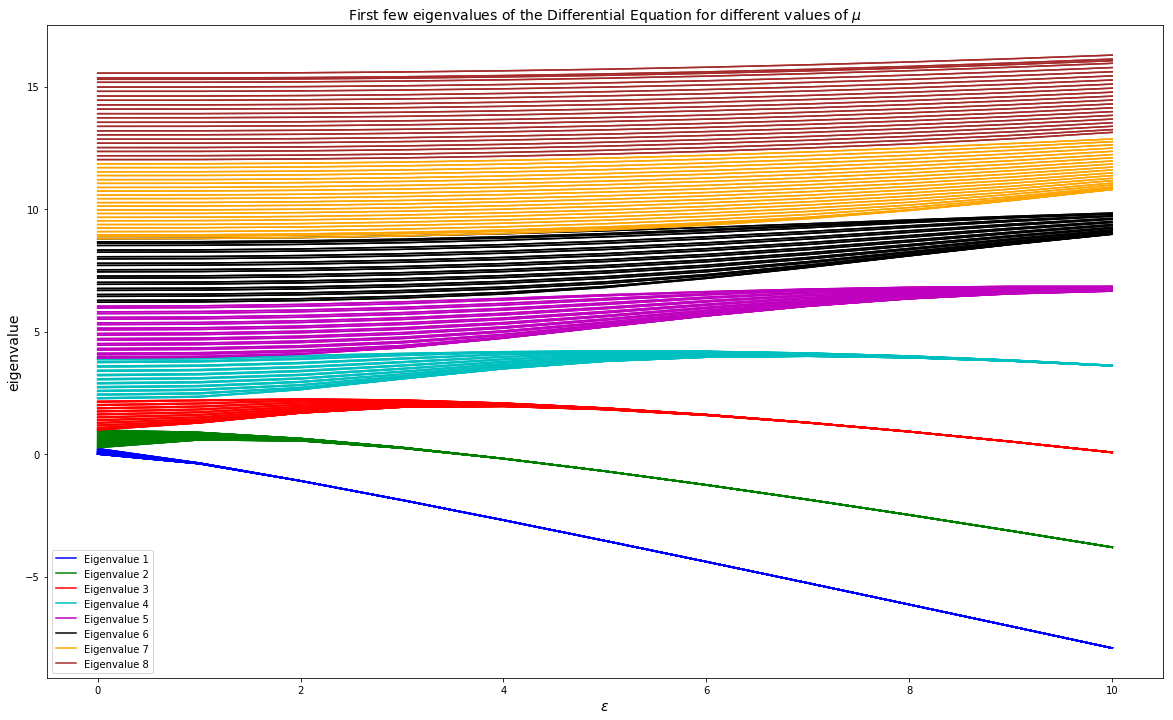

In [27]:
cols = ["b","g","r","c","m","k","orange","brown"]

plt.figure(figsize=(20,12))
for j in range(0,16):
    for kk in range(0,22):
        if ((kk == 0) and (j%2 == 0)):
            plt.plot(epsi,earr[kk,:,j],color=cols[j//2],label=("Eigenvalue "+str(j//2 + 1)))
        else:
            plt.plot(epsi,earr[kk,:,j],color=cols[j//2])
plt.title("First few eigenvalues of the Differential Equation for different values of $\mu$", fontsize = 14)
plt.legend()
plt.xlabel("$\epsilon$", fontsize = 14)
plt.ylabel("eigenvalue", fontsize = 14)

The graph shows clearly demarcated, non-overlapping bands for each eigenvalue. The shape of the bands is similar to the shape of the lines in the "first $8$ eigenvalues against $\epsilon$" graph. Interestingly, the bands narrow as $\epsilon$ increases, this implies that perturbations influence our solutions less when $\epsilon$ is large. This could be because our differential equation is dominated by the cosine term (which is independent of $\mu$) when $\epsilon$ is large.

The non-overlapping banded structure implies that for each $\epsilon$, we can form discrete sets of bounded eigenfunctions through their corresponding set of eigenvalues for $\mu \in [0,1]$. For example, the two discrete sets of the so-called "first two eigenvalues" can be $[a,b]$ and $[c,d]$ respectively where $b<c$ (analogous to how we would identify the first two eigenvalues as $\lambda_1$ and $\lambda_2$) and these would define the first two discrete sets of eigenfunctions.

In [28]:
G = 2**8 #This is the dimension of the square matrix.
xlin = linspace(0,2*pi,G)
epsi = 10
mu = linspace(0,1,22)

evarr,evarr2 = np.empty((22,G)), np.empty((22,G))
for j in range(0,22):
    FDm = FD2mat3(xlin,epsi,mu[j])
    results = np.linalg.eig(FDm)
    order = np.argsort(results[0])[0] #We pick the first eigenfunction
    order2 = np.argsort(results[0])[2] #We pick the second eigenfunction
    evarr[j,:] = np.abs(results[1])[:,order]
    evarr2[j,:] = np.abs(results[1])[:,order2]

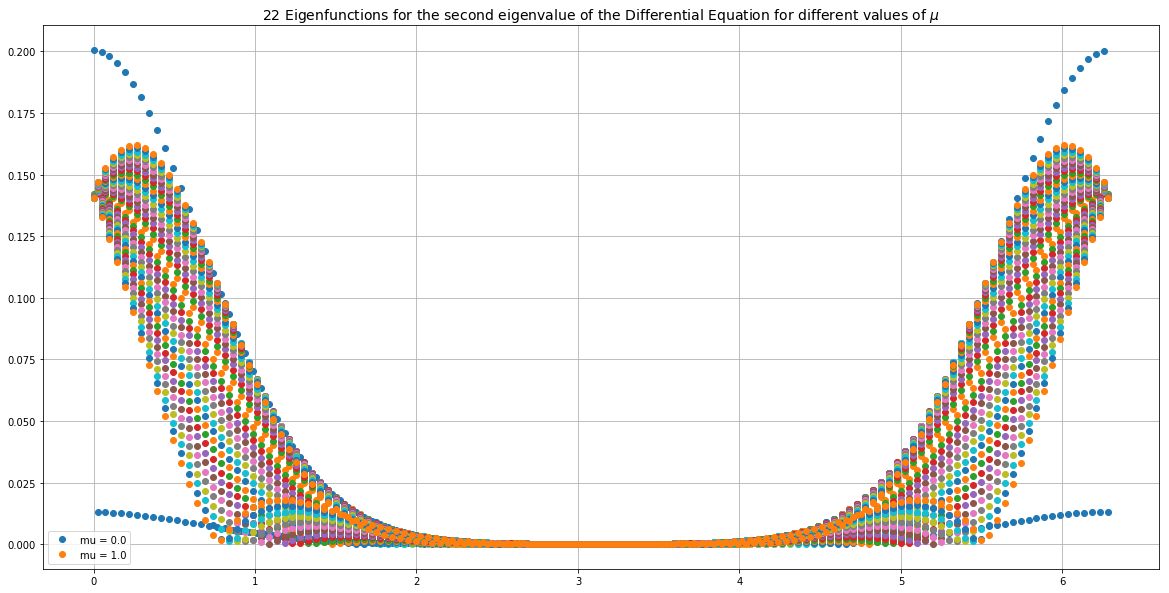

In [29]:
plt.figure(figsize=(20,10))
plt.title("22 Eigenfunctions for the second eigenvalue of the Differential Equation for different values of $\mu$", fontsize = 14)
for j in range(0,22):
    if ((j == 0) or (j == 21)):
        plt.plot(xlin,evarr[j,:],'o',label=("mu = "+str(j/21)))
    else:
        plt.plot(xlin,evarr[j,:],'o')
plt.legend()
plt.grid()

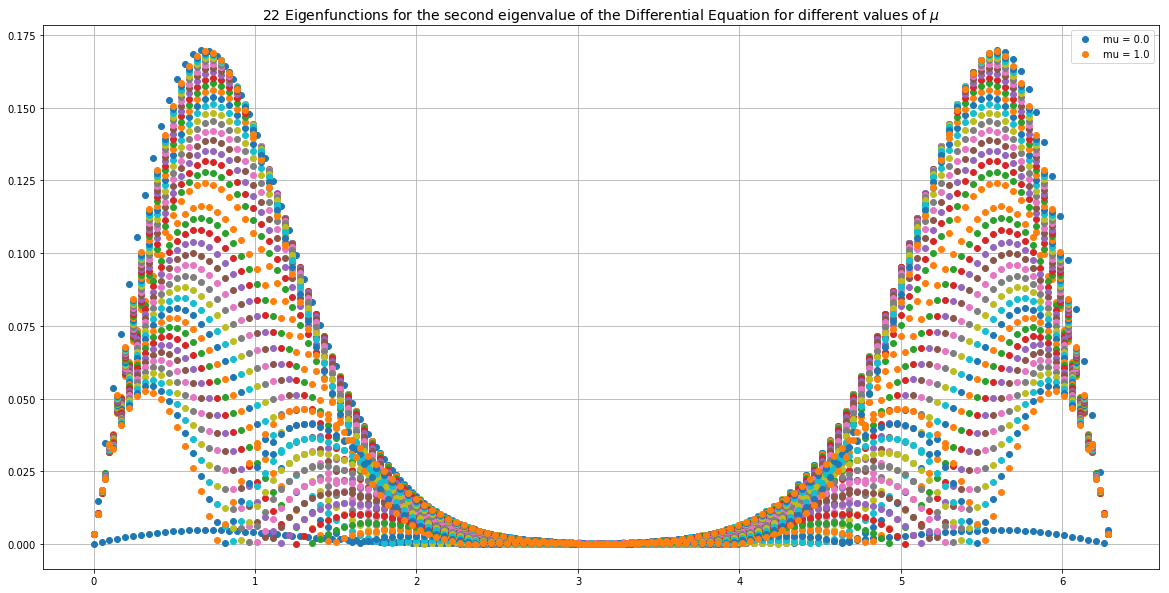

In [30]:
plt.figure(figsize=(20,10))
plt.title("22 Eigenfunctions for the second eigenvalue of the Differential Equation for different values of $\mu$", fontsize = 14)
for j in range(0,22):
    if ((j == 0) or (j == 21)):
        plt.plot(xlin,evarr2[j,:],'o',label=("mu = "+str(j/21)))
    else:
        plt.plot(xlin,evarr2[j,:],'o')
plt.legend()
plt.grid()

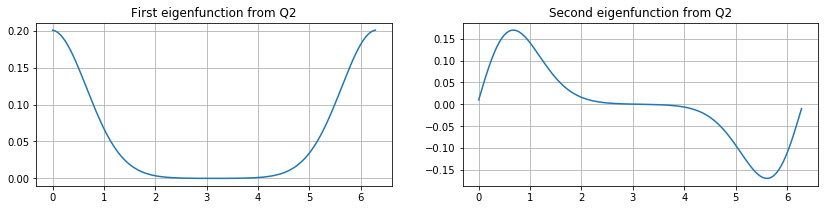

In [31]:
xlin = linspace(0,2*pi,2**7)

plt.figure(figsize=(14, 3))
plt.subplot(1,2,1)
plt.plot(xlin,uniquev[:,0])
plt.title("First eigenfunction from Q2")
plt.grid()

plt.subplot(1,2,2)
plt.plot(xlin,uniquev[:,1])
plt.title("Second eigenfunction from Q2")
plt.grid()

Each eigenvalue actually returns two eigenfunctions. This matches the fact that each eigenvalue is duplicated once. The eigenfunctions largely match the eigenfunctions we found in Q2, even with the correct scale, except with all negative points reflected upward due to the square in the differential equation. Though the smaller eigenfunction of each pair of eigenfunctions is conspicuously missing from our Q2 results. (Our Q2 eigenvalue results had no duplicates).

Lastly, it appears that for $\mu \in [0,1]$ the eigenfunctions are all enveloped by the pair of non-perturbed ($\mu = 0$) eigenfunctions.

## Q6

For every $x_k \in \{x_0,\ldots,x_{N+1}\}$, we can use a truncated Fourier Series to make the approximation:
$$u\left(x_k\right) \approx \sum^N_{n = -N} c_n e^{in x_k},$$

since our solution $u$ is $2 \pi$ periodic.

Therefore, we can manipulate our differential equation as such

\begin{align*}
&-\left(\frac{d^2}{dx^2}\left((e^{i\mu x})u(x)\right) + \epsilon \cos(x) e^{i\mu x} u(x)\right) = \lambda e^{i\mu x} u(x) \\
&\implies -\left(\frac{d^2}{dx^2}\left((e^{i\mu x})\sum^N_{n = -N} c_n e^{in x}\right) + \epsilon \cos(x) e^{i\mu x} u(x)\right) = \lambda e^{i\mu x} u(x) \\
&\implies -\left(\sum^N_{n = -N}\frac{d^2}{dx^2}\left( c_n e^{i(n + \mu) x}\right) + \epsilon \cos(x) e^{i\mu x} u(x)\right) = \lambda e^{i\mu x} u(x) \\
&\implies -\left(\sum^N_{n = -N}-(n+\mu)^2\left( c_n e^{i(n + \mu) x}\right) + \epsilon \cos(x) e^{i\mu x} u(x)\right) = \lambda e^{i\mu x} u(x) \mbox{ by property of Fourier Series} \\
&\implies -\left(\sum^N_{n = -N}-(n^2+\mu^2+n\mu)\left( c_n e^{i(n + \mu) x}\right) + \epsilon \cos(x) e^{i\mu x} u(x)\right) = \lambda e^{i\mu x} u(x) \\
&\implies -\left(\sum^N_{n = -N}-(n^2+n\mu) c_n e^{in x} + \left(-\mu^2 + \epsilon \cos(x)\right)u(x)\right) = \lambda u(x) \\
&\implies \sum^N_{n = -N}(n^2+n\mu) c_n e^{in x} + \left(\mu^2 - \epsilon \cos(x)\right)u(x) = \lambda u(x)
\end{align*}



In [66]:
def lastmat(xvals,n,epsi,mu): #Form the matrix for which we want to find the eigenvalues.
    N = len(xvals)
    mat = ((n + mu)**2)*np.eye(N) - epsi*np.diag(cos(xlin))
    
    return mat

In [74]:
xlin = linspace(0,2*pi,2**7)
FDm = lastmat(xlin,5,10,0)

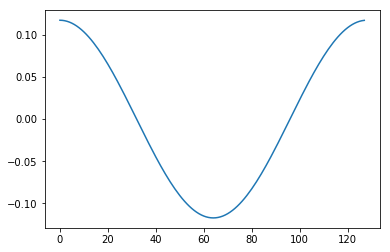

In [75]:
plt.plot(np.fft.fft(FDm)[1]/len(xlin))

c:\users\dionh\appdata\local\programs\python\python36\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


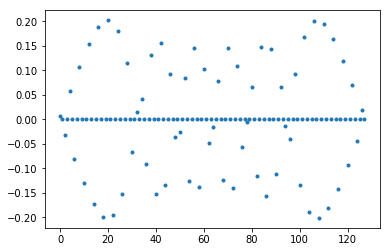

In [33]:
sorted(np.linalg.eig(FDm)[0])[0:8]
plt.plot((np.linalg.eig(FDm)[1])[:,6],'.')

In [34]:
plt.plot((np.fft.fft(np.linalg.eig(FDm))),'.')

ValueError: could not broadcast input array from shape (128,128) into shape (128)

In [ ]:
plt.plot(np.linalg.eig(FD2mat3(xlin,10,0))[1][:,40],'.')

In [ ]:
plt.plot(np.fft.fft(FD2mat3(xlin,10,0))[:,5],'.')

In [ ]:
plt.plot(np.linalg.eig(FD2mat3(xlin,10,0))[1][:,5],'.')

In [ ]:
def DFT2D(n):
    j = np.arange(n)
    k = j.reshape((n,1))
    M = np.exp(-2j*np.pi*k*j/n)
    kk=np.append(np.array(range(0, n // 2)),np.array([0]))
    kk=np.append(kk,np.array(range(-n // 2 + 1,0)))
    return ((-kk**2)*M / np.sqrt(n))

In [ ]:
def DFT(n):
    j = np.arange(n)
    k = j.reshape((n,1))
    M = np.exp(-2j*np.pi*k*j/n)
    return (M / np.sqrt(n))